Workflow(12.12):

* Get pixel coordinates at the level 0(check level connection).-----> classify into different classes.   
* Sample coordinates and read slide.(/255 data preprocess).  
* Data augmentation for tumor patches. 
* Build models: transfer learning, single-scale custom model and multi-scale model. 
* Predict and plot heatmap. 
* Evaluation: ROC, recall, precision and FROC. 

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

In [0]:
# # Install the OpenSlide C library and Python bindings
# !apt-get install openslide-tools
# !pip install openslide-python

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import keras
import urllib
import tensorflow as tf
import gc

Using TensorFlow backend.


## Step 0: Get Patches and Labels

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [4]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

In [0]:
def data_aug(x,y):
  
  """This function will implement data augumentation for patches
  
  Arguments:
    x: patches
    y: labels
      
  Returns:
    returns augumented patches and labels
    
  """
  
  #rotate 4 directions and left-right flip
  x1 = tf.image.rot90(x)
  x2 = tf.image.rot90(x1)
  x3 = tf.image.rot90(x2)
  x4 = tf.image.rot90(x3)
  x5 = x1[:, ::-1]
  x6 = x2[:,::-1]
  x7 = x3[:,::-1]
  x8 = x4[:,::-1]
  x_new=np.vstack([x1.numpy(),x2.numpy(),x3.numpy(),x4.numpy(),
                  x5.numpy(),x6.numpy(),x7.numpy(),x8.numpy()])
  
  #perturb color
  #x_new=tf.image.random_brightness(x_new,64/255)
  #x_new=tf.image.random_saturation(x_new,0,0.25)
  #x_new=tf.image.random_hue(x_new,0.04)
  #x_new=tf.image.random_contrast(x_new,0,0.75)
  y_new=np.repeat(y,8)
  
  #return x_new.numpy(), y_new
  return x_new, y_new

In [0]:
# Version 1.0
def data_preprocess(slide,tumor_mask,zoom_level,samples,
                    window_size=(299,299),center_size=(128,128)):
  
  #Fine valid pixels
  factor = int(slide.level_downsamples[zoom_level])
  slide_image = read_slide(slide,x=0, y=0, level=zoom_level, width=slide.level_dimensions[zoom_level][0],
                           height=slide.level_dimensions[zoom_level][1])
  coors = find_tissue_pixels(slide_image) 
  
#   del slide_image
#   gc.collect()
  
  mask_image = read_slide(tumor_mask, x=0, y=0, level=zoom_level, width=slide.level_dimensions[zoom_level][0], 
                          height=slide.level_dimensions[zoom_level][1])
  mask_image = mask_image[:,:,0]
  
  #Extract patches
  x_step = window_size[0]//2
  y_step = window_size[1]//2
  patches = np.zeros((samples,window_size[0],window_size[1],3))
  labels = np.zeros(samples)
  count = 0
  #num_grid= (((slide_image.shape[0]-window_size+1)//stride)+1)*(((slide_image.shape[1]-window_size+1)//stride)+1)
  
  while count < samples:
    coor = coors[np.random.choice(len(coors))]
    x_pos = coor[0] + x_step
    y_pos = coor[1] + y_step
    label = mask_image[(x_pos-center_size[0]//2):(x_pos+center_size[0]//2),
                       (y_pos-center_size[1]//2):(y_pos+center_size[1]//2)]
    if np.sum(label) == 0 and np.random.uniform(size=1) < 0.95:
      try:
        patches[count,:,:,:] = slide_image[(x_pos-window_size[0]//2):(x_pos+window_size[0]//2),(y_pos-window_size[1]//2):(y_pos+window_size[1]//2),:]/255.
      except: 
        continue
      else:
        labels[count] = 0.
        count += 1
    elif np.sum(label) == 0 and np.random.uniform(size=1) > 0.95:
      continue
    elif np.sum(label) != 0:
      #img = read_slide(slide, coor[0]*factor,coor[1]*factor, zoom_level, window_size[0],window_size[1])/255.
      img = slide_image[(x_pos-window_size[0]//2):(x_pos+window_size[0]//2),(y_pos-window_size[1]//2):(y_pos+window_size[1]//2),:]/255.
      if count + 8 > samples:
        temp1, temp2 = data_aug(img,1)
        labels[count:] = temp2[:(samples-count)]
        temp1_2= temp1.reshape(-1,)
        patches[count:,:,:,:] = temp1_2.reshape(8,window_size[0],window_size[1],3)[:(samples-count)]
      else:
        temp,labels[count:(count+8)] = data_aug(img,1)
        patches[count:(count+8),:,:,:] = (temp.reshape(-1,)).reshape(8,window_size[0],window_size[1],3)
      count += 8
      
  return patches, labels

In [0]:
# # Version 2.0
# def data_preprocess(slide,tumor_mask,zoom_level,
#                     window_size=(299,299),center_size=(128,128)):
  
#   #Fine valid pixels
#   factor = int(slide.level_downsamples[zoom_level])
#   mask_image = read_slide(tumor_mask, x=0, y=0, level=zoom_level, width=slide.level_dimensions[zoom_level][0], 
#                           height=slide.level_dimensions[zoom_level][1])
#   mask_image = mask_image[:,:,0]
  
#   #Extract patches
#   x_step = window_size[0]//2
#   y_step = window_size[1]//2
#   num_grid= (((mask_image.shape[0]-window_size[0]+1)//stride)+1)*(((mask_image.shape[1]-window_size[1]+1)//stride)+1)
#   patches = np.zeros((num_grid,mask_image.shape[0],mask_image.shape[1],3))
#   labels = np.zeros(num_grid)
#   count = 0
#   coors = zip(range(0,mask_image.shape[0]-window_size[0]),range(0,mask_image.shape[1]-window_size[1]))
  
#   while count < num_grid:
#     coor = coors[np.random.choice(len(coors))]
#     x_pos = coor[0] + x_step
#     y_pos = coor[1] + y_step
#     label = mask_image[(x_pos-center_size[0]//2):(x_pos+center_size[0]//2),
#                        (y_pos-center_size[1]//2):(y_pos+center_size[1]//2)]
#     if np.sum(label) == 0 and np.random.uniform(size=1) < 0.95:
#       patches[count,:,:,:] = read_slide(slide, coor[0]*factor,coor[1]*factor, zoom_level, window_size[0], window_size[1])/255.
#       labels[count] = 0.
#       count += 1
#     elif np.sum(label) == 0 and np.random.uniform(size=1) > 0.95:
#       continue
#     elif np.sum(label) != 0:
#       img = read_slide(slide, coor[0]*factor,coor[1]*factor, zoom_level, window_size[0],window_size[1])/255.
#       #img = slide_image[(x_pos-window_size[0]//2):(x_pos+window_size[0]//2),(y_pos-window_size[1]//2):(y_pos+window_size[1]//2),:]/255.
#       if count + 8 > num_grid:
#         temp1, temp2 = data_aug(img,1)
#         labels[count:] = temp2[:(num_grid-count)]
#         patches[count:,:,:,:] = temp1.reshape(8,window_size[0],window_size[1],3)[:(num_grid-count)]
#       else:
#         temp,labels[count:(count+8)] = data_aug(img,1)
#         patches[count:(count+8),:,:,:] = temp.reshape(8,window_size[0],window_size[1],3)
#       count += 8
      
#   return patches, labels

In [0]:
zoom_level=3
window_size=(150,150)
center_size=(100,100)
stride =100

In [0]:
patches,labels=data_preprocess(slide,tumor_mask,zoom_level=zoom_level,samples=3000,
                               window_size=window_size,center_size=center_size)

In [11]:
np.unique(labels,return_counts=True)

(array([0., 1.]), array([1590, 1410]))

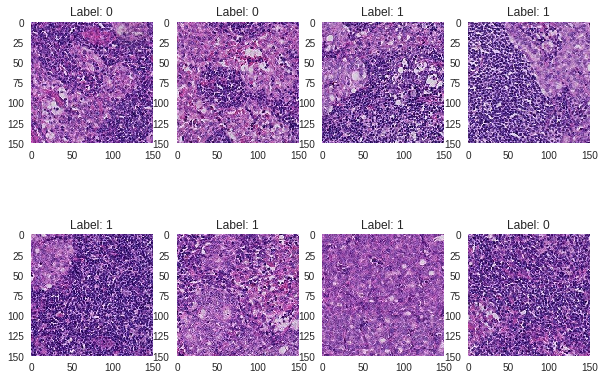

In [13]:
#Show some patches that we've got
plt.figure(figsize=(10,15))
count=1
for i in np.random.choice(len(patches),8):
  plt.subplot(4,4,count)
  plt.imshow((patches[i]*255).astype('uint8'))
  plt.grid(False)
  plt.title('Label: {}'.format(labels[i].astype('uint8')))
  count += 1

## Step 1: Transfer Learning

In [0]:
import keras.backend as K

def build_model(window_size):
  model = tf.keras.applications.InceptionV3(input_shape=(window_size, window_size, 3), 
                                                         include_top=False)
  model.trainable = False
  x = model.output
  x = tf.keras.layers.Flatten()(x)
  #x = tf.keras.layers.Dropout(0.3)(x)
  #x = tf.keras.layers.Dense(16, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  predictions = tf.keras.layers.Dense(1, activation="sigmoid")(x)

  def custom_loss_4(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred) * 5000)
  
  # creating the baseline model 
  model_baseline = tf.keras.models.Model(inputs = model.input, outputs = predictions)
  model_baseline.compile(loss =custom_loss_4, #"binary_crossentropy",
                         optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0001),
                         #optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001),
                         metrics=["accuracy"])
  return model_baseline

In [0]:
window_size = (150,150)
center_size = (100,100)
epochs = 5
batch_size = 32

In [0]:
model = build_model(window_size[0])

In [0]:
model.fit(patches,labels,epochs=epochs,batch_size=batch_size,validation_split=0.25)

## Step 2: Plot Heatmap of Probability

In [0]:
def get_patches_test(slide,zoom_level,
                     window_size=(150,150),center_size=(100,100),stride=100):
  
  slide_image = read_slide(slide,x=0, y=0, level=zoom_level, width=slide.level_dimensions[zoom_level][0],
                           height=slide.level_dimensions[zoom_level][1])
  mask_image = read_slide(tumor_mask, x=0, y=0, level=zoom_level, width=slide.level_dimensions[zoom_level][0], 
                          height=slide.level_dimensions[zoom_level][1])
  mask_image = mask_image[:,:,0]
  num_grid= (((slide_image.shape[0]-window_size[0]+1)//stride)+1)*(((slide_image.shape[1]-window_size[1]+1)//stride)+1)
  imgs=np.zeros((num_grid,window_size[0],window_size[1],3))
  labels=np.zeros(num_grid)
  half_grid=center_size[0]//2
  count=0
  
  for i in range(0,slide_image.shape[0]-window_size[0]+1,stride):
    for j in range(0,slide_image.shape[1]-window_size[1]+1,stride):
      x_pos=i+center_size[0]
      y_pos=j+center_size[1]
      grid_slide=slide_image[i:(i+window_size[0]),j:(j+window_size[1]),:]
      imgs[count,:,:,:]=grid_slide
      grid_label=mask_image[(x_pos-half_grid):(x_pos+half_grid),(y_pos-half_grid):(y_pos+half_grid)]
      if np.mean(grid_label) != 0:
        labels[count]=1.
      count += 1
      #labels[count] = np.argmax([np.mean(grid_label==0), np.mean(grid_label==1)*128, np.mean(grid_label==2)/2])
      #count += 1
    
  return imgs, labels

In [0]:
patches_test, labels_test,slide_image, mask_image = get_patches_test(slide,zoom_level,
                                                                     window_size=window_size,center_size=center_size,stride=stride)

In [0]:
y_pred = model.predict(patches_test)

In [0]:
## convert labels to mask
def label2mask(y_pred, mask_size, window_size=(150,150),center_size=(100,100),stride=100):
  
  mask_pred=np.zeros(mask_size)
  count=0
  x_grid=center_size[0]//2
  y_grid=center_size[1]//2
  for i in range(0,mask_size[0]-window_size[0],stride):
    for j in range(0,mask_size[1]-window_size[1],stride):
      x_pos=i+window_size[0]//2
      y_pos=j+window_size[1]//2
      if count >= len(y_pred):
        count -= 1
      mask_pred[(x_pos-x_grid):(x_pos+x_grid),(y_pos-y_grid):(y_pos+y_grid)]=y_pred[count]
      count += 1
  return(mask_pred)

In [0]:
mask_pred = label2mask(y_pred, mask_image.shape, window_size = window_size, center_size=center_size, stride = stride)

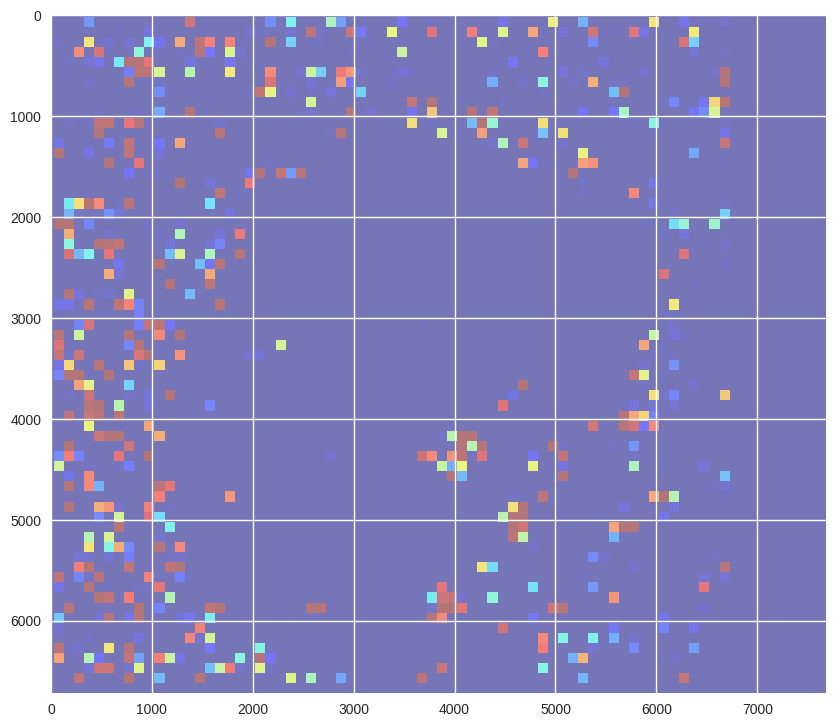

In [0]:
plt.figure(figsize=(10,10), dpi=100)
#plt.imshow(slide_image)
plt.imshow(mask_pred, cmap='jet', alpha=0.5) # Red regions contains cancer.

## Step 3: Evaluation

In [0]:
y_pred=y_pred_test_custom.copy()
y_pred[y_pred_test_custom!=1]=0.

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(labels_test, y_pred, pos_label=None)

print('AUC:%s'%(metrics.auc(fpr, tpr)))

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr)
plt.show()

In [0]:
recall=sklearn.metrics.recall_score(labels_test,y_pred)
precision=sklearn.metrics.precision_score(labels_test,y_pred)
print 'Recall:{}'.format(recall)
print 'Precision:{}'.format(precision)